# Pset 04: A Plague of Sand Mice

Throughout this notebook, I'll be annotating each section in "real time"--that is, I'll write down some preliminary hypotheses and ideas before I start coding, and then I'll write down some observations after I've finished the section and looked at the output.

At the end, I'll include a section where I play around with the data some more and discuss my findings/further thoughts.

# 1. test Moriarty's method yourself

We were told that Moriarty's scoring method is to score +1 for each A or T, and -1 for each C or G. Based on the histogram Moriarty provided, the scores of the random sequences were centered around 0 (as expected, because all bases are equally likely). However, the scores of the pathogen sequences were generally quite positive.

Sean mentioned in lecture that there's a slight mutational bias towards A/T in biological sequences. Therefore, it seems that Moriarty's scoring method gets great separation between random and pathogen sequences simply because of this bias. However, since this A/T bias is present in both sandmouse and pathogen sequences, their scores would be **comparable** unless there's some additional factor in play. I expect that A/T vs. G/C distribution is *not* the distinguishing factor of pathogen sequences, so I expect that Moriarty's scoring method will do a very poor job at distinguishing sandmouse vs. pathogen.

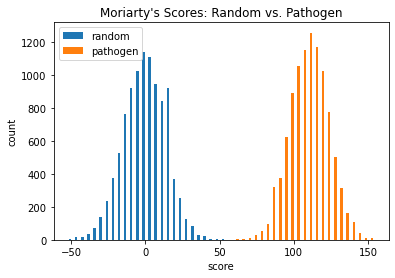

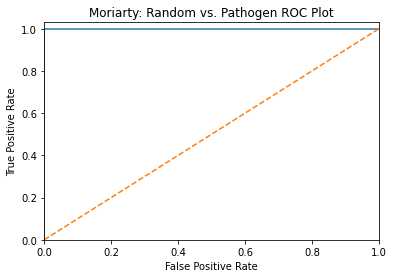

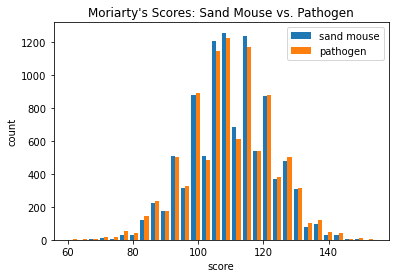

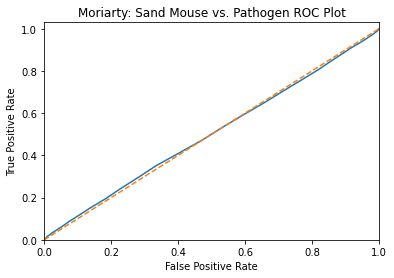

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

#implementing moriarty's scoring method
def moriartyScore(seq):
    #checking to make sure it's a valid dna seq
    if seq.count('A')+seq.count('T')+seq.count('C')+seq.count('G') != len(seq):
        print("Unexpected Nucleotide")
        return 999999 #if i see a 999999 in the histogram i know something's wrong
    return seq.count('A')+seq.count('T')-seq.count('C')-seq.count('G')

#read + store sequences
randSeqs=[] #stores 10k random seqs
pathogenSeqs=[] #stores 10k pathogen seqs
sandmouseSeqs=[] #stores 10k sandmouse seqs

#read files
with open('moriarty-neg.fa', 'r') as f:
    for line in f:
        line = line.rstrip('\n')
        if line[0] == '>': continue #skip all label lines
        randSeqs.append(line)

with open('sandmouse.fa', 'r') as f:
    for line in f:
        line = line.rstrip('\n')
        if line[0] == '>': continue #skip all label lines
        sandmouseSeqs.append(line)
        
with open('pathogen.fa', 'r') as f:
    for line in f:
        line = line.rstrip('\n')
        if line[0] == '>': continue #skip all label lines
        pathogenSeqs.append(line)

#compute scores for random, pathogen, sandmouse
randScores = [moriartyScore(seq) for seq in randSeqs]
pathogenScores = [moriartyScore(seq) for seq in pathogenSeqs]
sandmouseScores = [moriartyScore(seq) for seq in sandmouseSeqs]

#replicating Moriarty's histogram+ROC
plt.hist([randScores,pathogenScores], label = ['random', 'pathogen'], bins = 50)
plt.title("Moriarty's Scores: Random vs. Pathogen")
plt.xlabel('score')
plt.ylabel('count')
plt.legend()
plt.show()

#sklearn.metrics roc_curve outputs arrays of fpr, tpr, and thresholds
#setting the threshold at threshold[i] yields a fpr of fpr[i] and a tpr of tpr[i]
fpr, tpr, thresholds = roc_curve([1]*len(pathogenSeqs)+[0]*len(randSeqs), pathogenScores+randScores)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Moriarty: Random vs. Pathogen ROC Plot')
plt.show()

#plotting histogram+ROC for pathogen vs. sandmouse
plt.hist([sandmouseScores,pathogenScores],label = ['sand mouse', 'pathogen'], bins = 30)
plt.title("Moriarty's Scores: Sand Mouse vs. Pathogen")
plt.xlabel('score')
plt.ylabel('count')
plt.legend()
plt.show()

fpr_new, tpr_new, thresholds_new = roc_curve([1]*len(pathogenSeqs)+[0]*len(sandmouseSeqs), pathogenScores+sandmouseScores)

plt.figure()
plt.plot(fpr_new, tpr_new)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Moriarty: Sand Mouse vs. Pathogen ROC Plot')
plt.show()

We replicated Moriarty's results in the top two figures, which showed that his method clearly distinguishes **random vs. pathogen** sequences. In the bottom two figures, we see that his method **does not** distinguish between sand mouse and pathogen sequences. 

Therefore, all Moriarty's method does is discriminate between **biological sequences** (which will have a slight A/T bias, and thus a generally positive score) and **random sequences** of uniform base composition (and thus a score distribution centered around 0). This is pretty useless when it comes to distinguishing between sandmouse and pathogen sequences, because they both fall under the category of "biological sequences".

# 2. make your own method

### Strategy

I'll try to set this model up so that it won't be too hard to generalize to a nth-order Markov model. The key strategy I'll use here is to **map each sequence of length n uniquely to an integer in $[0,4^{n}-1]$.** In order to do this, I'll first specify a map $\{A,C,G,T\} \to \{0,1,2,3\}$, apply this map pointwise to any DNA sequence to get a base-$4$ number, and then convert that base-$4$ number to base $10$. For ease of debugging, I'll write separate methods for length $2$ and length $3$ sequences. However, this shouldn't be too hard to generalize to length $n$ sequences if one were to use a $n$th order Markov model.

This hashing method allows me to store $k$-mer frequencies and conditional probabilities in a **compact manner**. I store the frequency of a $k$-mer in a 1-dimensional array of length $4^{k}$, where index $i$ represents the *unique* string that maps to $i$ under the hashing scheme described above. Similarly, I store conditional probabilities $P(\text{n-mer} | \text{preceding k-mer})$ as a 2-dimensional array with dimensions $4^{n}$ by $4^{k}$. Here I only need to implement the $(n,k)=(1,2)$ case, but this once again generalizes readily.

### Predictions
I expect that the second-order Markov model will work pretty well in differentiating between sand mouse and pathogen sequences, but it won't be perfect. It seems very unlikely to me that capturing the "context" of the previous 2-mer is enough to produce a *perfect* split, but it certainly can produce quite decent results. This will be reflected in a histogram with some overlap (but not a lot), and a ROC curve that approaches 1 pretty rapidly.

In [4]:
import random
from sklearn.model_selection import train_test_split #we'll need this to split into train/test

#randomly shuffle and split train/test data for each category
random.shuffle(pathogenSeqs)
pathogenSeqsTrain, pathogenSeqsTest = train_test_split(pathogenSeqs, train_size=5000, test_size=5000)
random.shuffle(sandmouseSeqs)
sandmouseSeqsTrain, sandmouseSeqsTest = train_test_split(sandmouseSeqs, train_size=5000, test_size=5000)

#we'll use this to convert a dna sequence of length n to an int in [0,4^n-1]
hash_map = {'A':0, 'C':1, 'G':2, 'T':3}
rev_hash_map = {0:'A', 1:'C',2:'G',3:'T'}

#IMPLEMENTING HASHING SCHEME OUTLINED IN DESCRIPTION

#maps a 2mer to a unique integer in [0,4^2-1]
def hash2(d):
    return hash_map[d[0:1]] + 4*hash_map[d[1:2]]

def unhash2(i): #reverse of hash2
    right = rev_hash_map[(i-i%4)/4]
    left = rev_hash_map[i%4]
    return left+right

#maps a 3mer to a unique integer in [0,4^3-1]
def hash3(d):
    return hash_map[d[0:1]] + 4*hash_map[d[1:2]]+16*hash_map[d[2:3]]

In [5]:
#initialize 2mer frequencies
pathogenTwoMerCounts = [0]*16
#index i will contain # of instances of the (unique)2-mer that hashes to i
for seq in pathogenSeqsTrain: #loop through our seqs
    for i in range(len(seq)-1):
        pathogenTwoMerCounts[hash2(seq[i:i+2])] += 1 #increment count in the correct place
        
sandmouseTwoMerCounts = [0]*16 #same thing here
for seq in sandmouseSeqsTrain:
    for i in range(len(seq)-1):
        sandmouseTwoMerCounts[hash2(seq[i:i+2])] += 1

#now that we have the counts, we normalize to get the frequencies
pathogenTwoMerFreqs = [pathogenTwoMerCounts[i]/sum(pathogenTwoMerCounts) for i in range(len(pathogenTwoMerCounts))]
sandmouseTwoMerFreqs = [sandmouseTwoMerCounts[i]/sum(sandmouseTwoMerCounts) for i in range(len(sandmouseTwoMerCounts))]

#same for 3mer frequencies
pathogenThreeMerCounts = [0]*64
for seq in pathogenSeqsTrain:
    for i in range(len(seq)-2):
        pathogenThreeMerCounts[hash3(seq[i:i+3])] += 1
        
sandmouseThreeMerCounts = [0]*64
for seq in sandmouseSeqsTrain:
    for i in range(len(seq)-2):
        sandmouseThreeMerCounts[hash3(seq[i:i+3])] += 1

pathogenThreeMerFreqs = [pathogenThreeMerCounts[i]/sum(pathogenThreeMerCounts) for i in range(len(pathogenThreeMerCounts))]
sandmouseThreeMerFreqs = [sandmouseThreeMerCounts[i]/sum(sandmouseThreeMerCounts) for i in range(len(sandmouseThreeMerCounts))]

In [7]:
#pathogenConditionalProbs[hashed 1mer][hashed preceding 2mer]
# = pathogenThreeMerFreqs[combined 3mer]/pathogenTwoMerFreqs[2mer]

#stores list of conditional probabilities p(a|bc)
pathogenConditionalProbs=[[0 for x in range(16)] for y in range(4)]
for i in range(4):
    for j in range(16):
        #we can actually proceed directly to the final line without the unhashing/rehashing
        #but this makes it more readable
        rightmost = rev_hash_map[i] #extract a
        leftTwo = unhash2(j) #extract bc
        threeMer = leftTwo + rightmost #trimer abc
        pathogenConditionalProbs[i][j] = pathogenThreeMerFreqs[hash3(threeMer)]/pathogenTwoMerFreqs[hash2(leftTwo)]
        #calculating probability p(a|bc) by approximating it as p(abc)/p(bc).

#same thing for sand mouse
sandmouseConditionalProbs=[[0 for x in range(16)] for y in range(4)]
for i in range(4):
    for j in range(16):
        rightmost = rev_hash_map[i] 
        leftTwo = unhash2(j)
        threeMer = leftTwo + rightmost
        sandmouseConditionalProbs[i][j] = sandmouseThreeMerFreqs[hash3(threeMer)]/sandmouseTwoMerFreqs[hash2(leftTwo)]

In [8]:
import math
#do this in log space to avoid underflow!
#takes a seq of length >=3 and outputs the conditional probability it's a pathogen seq
def logPathogenProb(seq):
    init = math.log(pathogenTwoMerFreqs[hash2(seq[0:2])]) #initialize: probability of first 3-mer
    for i in range(0,len(seq)-3): #loop over all 3-mers and multiply by P(a|bc)
        right=seq[i+2:i+3]
        leftTwo = seq[i:i+2]
        init += math.log(pathogenConditionalProbs[hash_map[right]][hash2(leftTwo)])
        #we ADD, not multiply, because it's in log space
    return init

#same thing as above for sandmouse
#takes a seq of length >=3 and outputs the conditional probability it's a sand mouse seq
def logSandmouseProb(seq):
    init = math.log(sandmouseTwoMerFreqs[hash2(seq[0:2])])
    for i in range(0,len(seq)-3):
        right=seq[i+2:i+3]
        leftTwo = seq[i:i+2]
        init += math.log(sandmouseConditionalProbs[hash_map[right]][hash2(leftTwo)])
    return init
    
def lod(seq): #this will be our final score for a sequence: + indicates more likely to be pathogen
    return logPathogenProb(seq)-logSandmouseProb(seq)
    #subtract, not divide, b/c in log space

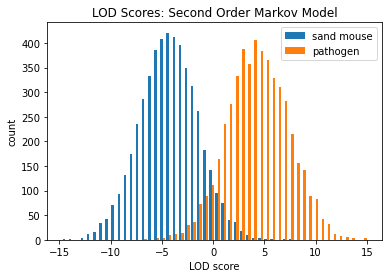

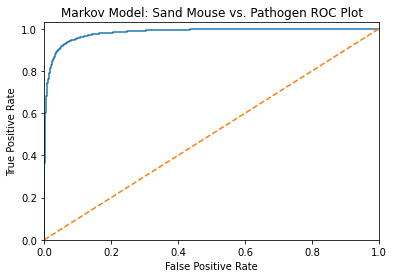

In [9]:
#plotting histogram+ROC for pathogen vs. sandmouse
pathogenLODs = [lod(seq) for seq in pathogenSeqsTest]
sandmouseLODs = [lod(seq) for seq in sandmouseSeqsTest]
plt.hist([sandmouseLODs,pathogenLODs],label = ['sand mouse', 'pathogen'], bins = 50)
plt.title("LOD Scores: Second Order Markov Model")
plt.xlabel('LOD score')
plt.ylabel('count')
plt.legend()
plt.show()

#make ROC curve using same method as section 1
fpr_new, tpr_new, thresholds_new = roc_curve([1]*len(pathogenSeqsTest)+[0]*len(sandmouseSeqsTest), pathogenLODs+sandmouseLODs)

#plot ROC curve
plt.figure()
plt.plot(fpr_new, tpr_new)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Markov Model: Sand Mouse vs. Pathogen ROC Plot')
plt.show()

As expected, we observe some overlap between the score distributions, but not too much. Overall, our second-order Markov model seems to reasonably differentiate between sand mouse and pathogen sequences. Additionally, we see that the ROC plot approahces 1 very quickly, and the area under the blue curve is almost 1. This indicates that our model can get a good true positive rate while still having a relatively low false positive rate.

This analysis seems to indicate that our model is working pretty well, but doesn't achieve *perfect* discrimination like Moriarty claims. This makes sense because it's unlikely that a second-order model can fully capture the differences between pathogen and sand mouse sequences (as these differences are likely to be complex and the mechanism may be unknown).

In the next sections, we'll dive deeper into the strengths and weaknesses of this model and quantify what exactly the tradeoff is between sensitivity and specificity.

# 3. how good is your method?

### Strategy

In this section, we'd like to find the least restrictive threshold that yields 90% sensitivity. From this, we're also asked to calculate the false positive rate and false discovery rate at that threshold. The implementation should be quite straightforward--we'll find the threshold and FPR using the ROC curve we computed above, and we can calculate FDR from there by assuming 1% of all reads are from the pathogen.

### Expectations

**When a disease is rare in a population, false discovery rates can be quite high.**

We can see this using the following thought experiment. Assume that a disease is present in $1$ in $1000$ people, and let's say we have a diagnostic assay which manages to achieve both 99% sensitivity (true positive rate) and 99% specificity (true negative rate). This seems quite good on the surface... 

Suppose every person in a country with 1 million people gets tested. $1000$ of them will have the disease, and $990$ will correctly test positive. $999000$ of them won't have the disease, but $0.01 \cdot 999000 = 9990$ of them will incorrectly test positive. Therefore, **given that someone tests positive, they only have a $\frac{990}{9990+990} \approx 9\% $ chance of actually having the disease.** Though the test managed to have a very high sensitivity and specificity, the false discovery rate was still $91\%$!

The same should apply here, though it's less extreme since we assume $1$ in $100$ (not $1000$) reads are from a pathogen. The low prior probability of a read being from a pathogen should result in a high FDR, regardless of how restrictive our threshold is.

Based on the ROC curve above, it seems like we can get a 90% sensitivity with a **pretty low false positive rate**. However, since we're given that the disease is somewhat rare (only 1% of all reads are from the pathogen), I still expect there to be a **high false discovery rate**.

In [23]:
optIndex = 0 #will give the first INDEX corresponding to a sensitivity of >=90%
while(tpr_new[optIndex]<0.9):
    optIndex += 1

print("The minimum LOD score threshold that gives a sensitivity of at least 90% is: " + str(round(thresholds_new[optIndex],3)))
print("The sensitivity at this threshold is: " + str(round(tpr_new[optIndex],4)*100) + "%")
#should be about 90%
print("The false positive rate at this threshold is: " + str(round(fpr_new[optIndex],4)*100) + "%") 
#false positive rate at 90% TPR

sFreq = 0.99 #given
pFreq = 0.01 #given

fp = fpr_new[optIndex]*sFreq #probability that a sequence is non-pathogen and incorrectly labeled as pathogen
tp = tpr_new[optIndex]*pFreq #probability that a sequence is pathogen and correctly labeled as pathogen
fdr = fp/(tp+fp)
print("The false discovery rate at this threshold is: " + str(round(fdr,4)*100) + "%")
#82.48 percent FDR -->in order to reduce this, we'd need a much lower FPR since theres so many more sand mouse seqs

The minimum LOD score threshold that gives a sensitivity of at least 90% is: 0.589
The sensitivity at this threshold is: 90.08%
The false positive rate at this threshold is: 4.38%
The false discovery rate at this threshold is: 82.8%


At a sensitivity of $90\%$, the false positive rate was less than $5\%$ (which seems okay). However, the false discovery rate was **very** high, at $82.8\%$. 

I suspect we can't do much better than this with the current model, because the pathogen frequency of $0.01$ is low and there's always a tradeoff between sensitivity, specificity, and FDR. I'll look at this more in the next section.

# 4. further exploration + conclusions

After completing the pset tasks, there are three main things I want to explore further.

### Optimizing for Other Metrics

In the last part, we picked an optimal threshold based on a certain threshold level of sensitivity alone. I'm curious about other ways we could approach picking an "optimal threshold". I'll find the threshold that maximizes the expression $TPR \cdot(1-FPR)$ and see if that produces any better results. Intuitively, I anticipate that this might not be too great of a metric because the $TPR$ varies very slowly within the "optimal range" relative to the $FPR$. However, this method can easily be adapted to maximize/minimize any metric of our choosing.

### Sensitivity vs. FDR Tradeoff

I'm interested to see whether we can get a better false discovery rate without compromising too much on sensitivity. My hypothesis is that **we can't**, unless we create a better model (like a higher-order Markov model). This is because **the prevalence of the pathogen is so low that you'd need an exceptionally high sensitivity AND specificity to get a low false discovery rate**. This would correspond to a (TPR, FPR) point which does not lie on the ROC plot for our model.

### Flexing on Moriarty

Finally, I'd like to train the same model on random sequences as well to show that what Moriarty did (distinguishing random vs. pathogen sequences) wasn't anything special. The A/T bias requires **no** sequential context to identify, so a zeroth order Markov model (so to speak), which just counts letter frequencies, would be able to pick up on the difference. Therefore, I expect our second-order model to easily differentiate between random and pathogen reads.

In [30]:
#figure out threshold that maximizes TPR*(1-FPR)
#what is the false discovery rate there?
bestIndex=0
maxMetric=0
for ind in range(len(tpr_new)):
    if tpr_new[ind]*(1-fpr_new[ind])>maxMetric: #check if it's better than our current max
        bestIndex = ind #if so, update
        maxMetric = tpr_new[ind]*(1-fpr_new[ind])
print("Our metric is TPR*(1-FPR).")
print("The LOD score threshold that maximizes this metric is: " + str(round(thresholds_new[bestIndex],3)))
print("The metric at this threshold is: " + str(round(maxMetric,3)))
print("The TPR at this threshold is: " + str(round(tpr_new[bestIndex],3)*100) + "%")
print("The FPR at this threshold is: " + str(round(fpr_new[bestIndex],3)*100) + "%")
print("The FDR at this threshold is: " + 
      str(round((fpr_new[bestIndex]*sFreq)/(fpr_new[bestIndex]*sFreq + tpr_new[bestIndex]*pFreq),4)*100) + "%")

Our metric is TPR*(1-FPR).
The LOD score threshold that maximizes this metric is: -0.05
The metric at this threshold is: 0.871
The TPR at this threshold is: 93.4%
The FPR at this threshold is: 6.7%
The FDR at this threshold is: 87.6%


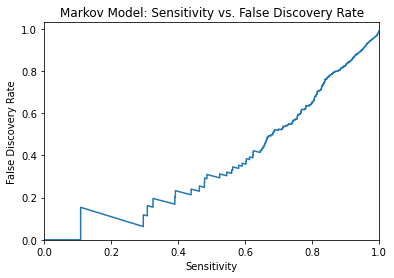

If you want a False Discovery Rate of at most 0.5, your sensitivity can be at most 0.6822.
If you want a False Discovery Rate of at most 0.25, your sensitivity can be at most 0.4634.
If you want a False Discovery Rate of at most 0.1, your sensitivity can be at most 0.1088.


In [37]:
#calculate what sensitivity you'd need in order to get a FDR below a certain cutoff -->make a graph of sensitivity vs. FDR.
#one of these points should be (90, 0.825) b/c we saw above that 90% sensitivity gave an unacceptably high FDR of 0.825.
#for analysis, look at certain points (what sensitivity would you need to get 50% FDR? how about 10%?)

fdr_new=[]
for i in range(len(tpr_new)):
    fp = fpr_new[i]*sFreq #probability that a sequence is non-pathogen and incorrectly labeled as pathogen
    tp = tpr_new[i]*pFreq #probability that a sequence is pathogen and correctly labeled as pathogen
    if(fp+tp > 0): #we must avoid division by 0
        fdr = fp/(tp+fp)
    elif fp==0:
        fdr = 0 #if there's no false positives, assign false discovery rate to be 0
    else: #if there's no true positives, assign false discovery rate to be 1
        fdr=1
    fdr_new.append(fdr)

plt.figure()
plt.plot(tpr_new, fdr_new)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('Sensitivity')
plt.ylabel('False Discovery Rate')
plt.title('Markov Model: Sensitivity vs. False Discovery Rate')
plt.show()

#determines max sensitivity we can get if we want to limit our false discovery % to a certain cutoff
def maxSensitivity(fdrCutoff):
    i=0
    while(fdr_new[i]<fdrCutoff):
        i += 1
    return tpr_new[i-1]

def printMaxSensitivity(fdrCutoff):
    print("If you want a False Discovery Rate of at most " + str(fdrCutoff) + ", your sensitivity can be at most " 
          + str(maxSensitivity(fdrCutoff)) + ".")
printMaxSensitivity(0.5)
printMaxSensitivity(0.25)
printMaxSensitivity(0.1)

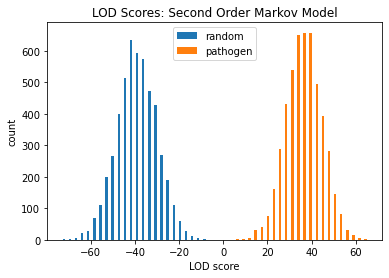

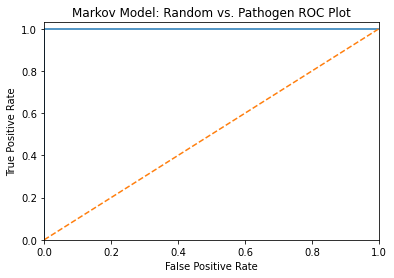

In [31]:
#exact same method as in the above tasks, for any code clarification check the corresponding segments above.
random.shuffle(pathogenSeqs)
randSeqsTrain, randSeqsTest = train_test_split(randSeqs, train_size=5000, test_size=5000)
       
randTwoMerCounts = [0]*16
for seq in randSeqsTrain:
    for i in range(len(seq)-1):
        randTwoMerCounts[hash2(seq[i:i+2])] += 1
        
randTwoMerFreqs = [randTwoMerCounts[i]/sum(randTwoMerCounts) for i in range(len(randTwoMerCounts))]

randThreeMerCounts = [0]*64
for seq in randSeqsTrain:
    for i in range(len(seq)-2):
        randThreeMerCounts[hash3(seq[i:i+3])] += 1

randThreeMerFreqs = [randThreeMerCounts[i]/sum(randThreeMerCounts) for i in range(len(randThreeMerCounts))]


randConditionalProbs=[[0 for x in range(16)] for y in range(4)]
for i in range(4):
    for j in range(16):
        rightmost = rev_hash_map[i] 
        leftTwo = unhash2(j)
        threeMer = leftTwo + rightmost
        randConditionalProbs[i][j] = randThreeMerFreqs[hash3(threeMer)]/randTwoMerFreqs[hash2(leftTwo)]
        
def logRandProb(seq):
    init = math.log(randTwoMerFreqs[hash2(seq[0:2])])
    for i in range(0,len(seq)-3):
        right=seq[i+2:i+3]
        leftTwo = seq[i:i+2]
        init += math.log(randConditionalProbs[hash_map[right]][hash2(leftTwo)])
    return init
    
def lod2(seq):
    return logPathogenProb(seq)-logRandProb(seq)

#plotting histogram+ROC for pathogen vs. sandmouse
pathogenLODs = [lod2(seq) for seq in pathogenSeqsTest]
randLODs = [lod2(seq) for seq in randSeqsTest]
plt.hist([randLODs,pathogenLODs],label = ['random', 'pathogen'], bins = 50)
plt.title("LOD Scores: Second Order Markov Model")
plt.xlabel('LOD score')
plt.ylabel('count')
plt.legend()
plt.show()

fpr2, tpr2, thresholds2 = roc_curve([1]*len(pathogenSeqsTest)+[0]*len(randSeqsTest), pathogenLODs+randLODs)

plt.figure()
plt.plot(fpr2, tpr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Markov Model: Random vs. Pathogen ROC Plot')
plt.show()

In the first experiment, we saw that maximizing $TPR*(1-FPR)$ actually makes our $FDR$ worse as it selects for a less conservative threshold. Our selected metric wasn't great, but maximizing for some more nuanced metrics might be useful depending on what the goal of your experiment is.

In the second experiment, we saw that **there's no good way to reduce our FDR without compromising sensitivity/specificity a LOT.** This corresponds with our hypothesis that we'd need a better model in order to make improvements in all three model parameters. There was a weird edge effect in the bottom left of the graph, but the sensitivity/specificity are both so low at that region anyway that it shouldn't affect our conclusion.

In the last experiment, we showed that our second-order Markov model was able to achieve complete discrimination between random and pathogen sequences. This was expected, but it's still a nice sanity check to make sure everything is working as expected.

Some key takeaways from this pset:
- Even at low order, stochastic models can perform decently on binary classification tasks.
- Make sure that you're actually testing something that will lead to meaningful results. Moriarty's "random vs. pathogen" result was *correct*, but entirely irrelevant to the experimental goal.
- It's often not enough to look at sensitivity/specificity and use ROC/AUC analysis to determine whether a model is "good enough". Depending on what is considered "acceptable" in the experimental context, it may be worth trying to optimize based on some composite metric.